In [1]:
from matplotlib import pyplot as plt
import numpy as np
import re

# Select all files to load via regex
regex = ".*"

# Files to load. t = num_timesteps, l = lut_depth, s = samples, w = reward weights
files = [
    f"lut_t={t}_l=2_w={'1'*t}_noise={noise}_s={s}"  for t in [2,3] for noise in [0.0] for s in range(3)
]

fidelities_each = []
loaded_files = []
for file in files:
    if not re.match(regex, file):
        continue

    data = np.load(f"{file}.npz")
    fidelities_each.append(data)
    loaded_files.append(file)

baseline_fidelities = np.load("baseline_fidelities.npz")["fidelities"]

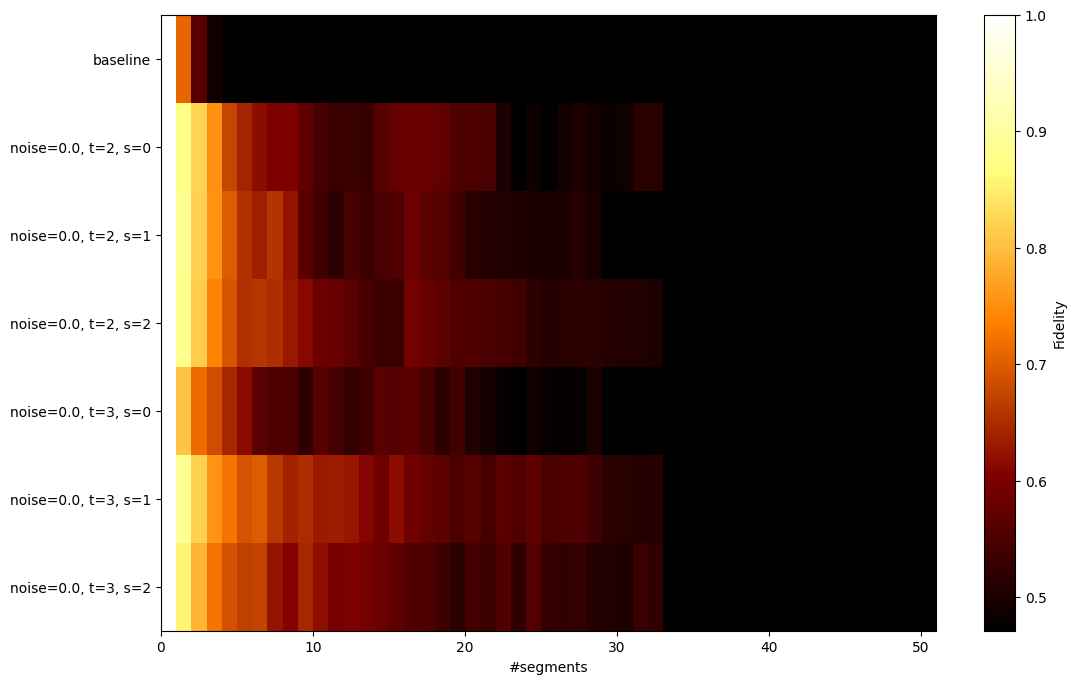

In [2]:
# Read fidelities into matrix and plot 2D graph
label_each = []
first_value = None
for value in fidelities_each[0].values():
    first_value = value
    break
fidelities_mat = np.zeros((len(fidelities_each), len(first_value)))

fig, ax = plt.subplots(1,1, figsize=(12.5,8))
for i, (filename, fidelities) in enumerate(zip(loaded_files, fidelities_each)):
    color = (
        "lightgrey" if "grape" in filename else
        "tab:blue"  if "lut" in filename else
        "tab:orange" # rnn
    )

    keyword = (
        "fidelities_grape" if "grape" in filename else
        "fidelities_lut"  if "lut" in filename else
        "fidelities_rnn" # rnn
    )

    F = fidelities[keyword]

    # extract variables from filename
    protocol = re.search(r'^(grape|lut|rnn)', filename).group(1)
    t = int(re.search(r't=(\d+)', filename).group(1))
    w = re.search(r'w=(\d+)', filename).group(1)
    s = int(re.search(r's=(\d+)', filename).group(1))
    noise = float(re.search(r'noise=([\d.]+|inf)', filename).group(1))

    if protocol == "lut":
        l = int(re.search(r'l=(\d+)', filename).group(1))
        label = f"noise={noise}, t={t}, s={s}"
    else:
        pass#label = f"{protocol}, t={t}, w={w}, noise={noise}"

    fidelities_mat[i,:] = F
    label_each.append(label)

# Add baseline fidelities as first row
fidelities_mat = np.vstack([baseline_fidelities, fidelities_mat])
label_each = ["baseline"] + label_each

im = ax.imshow(
    fidelities_mat,
    aspect="auto",
    cmap="afmhot",
    vmin=baseline_fidelities[-1], # for better contrast in colormap
    vmax=1.0,
    extent=[0, fidelities_mat.shape[1], fidelities_mat.shape[0], 0],
    interpolation="none",
)
fig.colorbar(im, ax=ax, label="Fidelity")

#ax.set_xlim(0, 10)
ax.set_xlabel("#segments")
ax.set_yticks(np.arange(len(label_each))+0.5)
ax.set_yticklabels(label_each)
#ax.axvline(x=3)
fig.savefig("fidelity_comparison", bbox_inches="tight")

[0.58441681 0.58448619 0.60200332 0.55864648 0.62620146 0.60387638]
0.6262014553790922


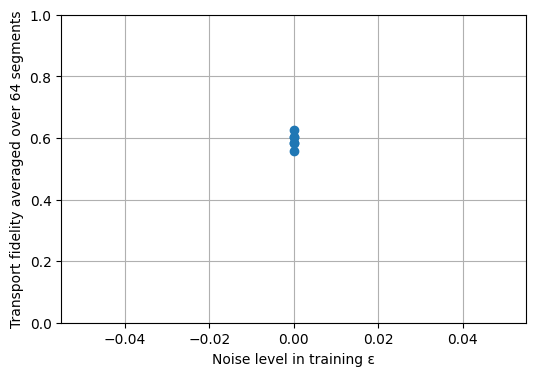

In [3]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
mean_fid = fidelities_mat[1:,:32].mean(axis=1)
print(mean_fid)
print(max(mean_fid))
noise = [float(re.search(r'noise=([\d.]+|inf)', filename).group(1)) for filename in loaded_files]
ax.plot(noise, mean_fid, marker='o')
ax.set_xlabel("Noise level in training ε")
ax.set_ylabel("Transport fidelity averaged over 64 segments")
ax.set_ylim(0,1)
ax.grid()

fig.savefig("mean_fidelity_vs_noise.png", bbox_inches="tight")